## Custom Generator

In [75]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, img_dir, img_list, mask_dir, mask_list):
        self.img_dir = img_dir
        self.img_list = img_list
        self.mask_dir = mask_dir
        self.mask_list = mask_list
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.img_list[idx])
        mask_name = os.path.join(self.mask_dir, self.mask_list[idx])
        
        image = np.load(img_name)
        mask = np.load(mask_name)
        
        return torch.from_numpy(image), torch.from_numpy(mask)


def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
    dataset = CustomDataset(img_dir, img_list, mask_dir, mask_list)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

### testing generator

In [36]:
from torch import nn
from matplotlib import pyplot as plt
import random

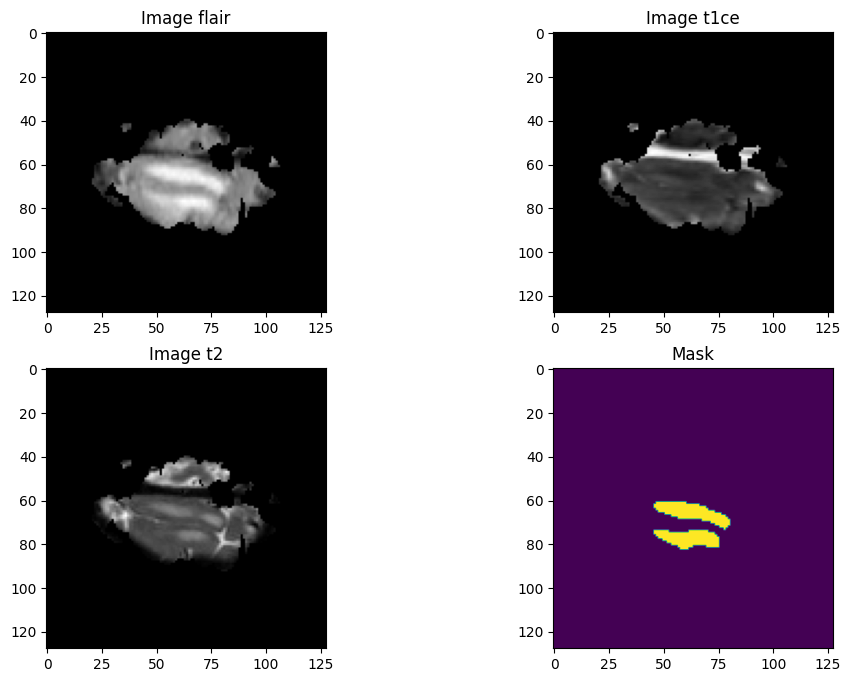

In [76]:
train_img_dir = "BraTS2021_TrainingData/input_data_128/train/images/"
train_mask_dir = "BraTS2021_TrainingData/input_data_128/train/masks/"

val_img_dir = "BraTS2021_TrainingData/input_data_128/val/images/"
val_mask_dir = "BraTS2021_TrainingData/input_data_128/val/masks/"

train_img_list= sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

val_img_list = sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))

batch_size = 4

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator
for img, msk in train_img_datagen:
    break  # Break after the first batch

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=2)
#print(test_mask.shape) #--> torch.Size([128, 128])


#print(img.shape) #--> torch.Size([2, 128, 128, 3])
#print(test_img.shape) #--> torch.Size([128, 128, 3])

plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:])
plt.title('Mask')
plt.show()

In [24]:
print(len(train_img_datagen))
print(len(train_mask_list))
print(len(val_img_datagen))
print(len(val_mask_list))

112
112
28
28


## deefinition of loss functions

In [78]:
class MultiClassDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(MultiClassDiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # inputs: [batch_size, num_classes, ...]
        # targets: [batch_size, num_classes, ...]

        dice_per_class = []
        for class_idx in range(inputs.size(1)):  # Iterate over classes
            class_inputs = inputs[:, class_idx, ...]
            #plt.imshow(class_inputs.detach().numpy()[:,70,:])
            class_targets = targets[:, class_idx, ...]
            
            # Compute Dice Loss for each class separately
            intersection = (class_inputs * class_targets).sum()
            dice = (2. * intersection + smooth) / (class_inputs.sum() + class_targets.sum() + smooth)
            dice_per_class.append(dice)

        # Average Dice Loss across all classes
        mean_dice_loss = torch.mean(torch.stack(dice_per_class))
        return 1 - mean_dice_loss
    

class MultiIoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(MultiIoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
          
        IoU_per_class = []
        for class_idx in range(inputs.size(1)):
            class_inputs = inputs[:, class_idx, ...]
            class_targets = targets[:, class_idx, ...]
        
            intersection = (class_inputs * class_targets).sum() # True Positive count
            total = (class_inputs + class_targets).sum()
            union = total - intersection  # mutually inclusive area of all labels & predictions 
        
            IoU = (intersection + smooth)/(union + smooth)
            IoU_per_class.append(IoU)

        mean_IoU_loss = torch.mean(torch.stack(IoU_per_class))
                
        return 1 - mean_IoU_loss

## Training

In [79]:
from exampleUnet2d import SA_UNet_8x8
model = SA_UNet_8x8()

In [81]:
LR = 0.0001
NUM_EPOCHS = 100
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

multi_dice = MultiClassDiceLoss()
multi_IoU = MultiIoULoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

### training loop

In [83]:
for epoch in range(10):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    
    for images, masks in train_img_datagen:
        images = images.float().to(device=DEVICE)
        masks = masks.float().to(device=DEVICE)
        masks = torch.transpose(torch.transpose(masks, 1, -1), 2, -1)
        optimizer.zero_grad()
        preds = model(torch.transpose(torch.transpose(images, 1, -1), 2, -1))

        loss = multi_dice(preds,masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_accuracy += multi_IoU(preds, masks).item()
        print("accuracy:", running_accuracy)

    epoch_loss = running_loss / len(train_img_datagen)
    epoch_accuracy = running_accuracy / len(train_img_datagen)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}:")
    print(f"  Train Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_accuracy:.4f}")

# Save the trained model
torch.save(model.state_dict(), 'brats_Unet3d.pth')

accuracy: 0.9298665523529053
accuracy: 1.8457250595092773
accuracy: 2.7524407505989075
accuracy: 3.670564830303192
accuracy: 4.57118022441864
accuracy: 5.494992256164551
accuracy: 6.399870276451111
accuracy: 7.32105952501297
accuracy: 8.249521851539612
accuracy: 9.164548814296722
accuracy: 10.07840484380722
accuracy: 11.01316124200821
accuracy: 11.925947964191437
accuracy: 12.847270965576172
accuracy: 13.767027378082275
accuracy: 14.684741973876953
accuracy: 15.60547810792923
accuracy: 16.518215835094452
accuracy: 17.422182202339172
accuracy: 18.33892285823822
accuracy: 19.259725689888
accuracy: 20.17617118358612
accuracy: 21.087046027183533
accuracy: 22.00943648815155
accuracy: 22.941338777542114
accuracy: 23.8639959692955
accuracy: 24.761994123458862
accuracy: 25.67144739627838
Epoch 1/100:
  Train Loss: 0.8569 | Train Accuracy: 0.9168
accuracy: 0.9155341982841492
accuracy: 1.8242927193641663
accuracy: 2.735040307044983
accuracy: 3.6570220589637756
accuracy: 4.5670859813690186
accura

In [84]:
modelLoad = SA_UNet_8x8()

modelLoad.load_state_dict(torch.load('brats_Unet3d.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [85]:
for imgs, msks in train_img_datagen:
    break

#print(imgs.shape, msks.shape) # --> torch.Size([2, 128, 128, 128, 3]) torch.Size([2, 128, 128, 128, 4])

img_num = random.randint(0, imgs.size(0)-1)
val_img = imgs[img_num].unsqueeze(0)
val_msk = msks[img_num].unsqueeze(0)

#print(val_img.shape, val_msk.shape) # --> torch.Size([1, 128, 128, 3]) torch.Size([1, 128, 128, 4])

In [86]:
val_pred = modelLoad(torch.transpose(torch.transpose(torch.transpose(val_img.float(), 1, -1), 2, -1), 2, -2))
print(val_pred.shape) # --> torch.Size([1, 4, 128, 128])

torch.Size([1, 4, 128, 128])


In [87]:
val_pred = val_pred[0] # shape = torch.Size([4, 128, 128])

In [88]:
val_pred = torch.transpose(torch.transpose(val_pred, 0, -1), 0, 1) # shape = torch.Size([128, 128, 4])
val_msk = val_msk[0] # shape = torch.Size([128, 128, 4])

In [89]:
val_img = val_img[0]
val_img = val_img.cpu().numpy()

In [90]:
val_pred = val_pred.cpu().detach().numpy()
val_msk = val_msk.cpu().numpy()

val_msk=np.argmax(val_msk, axis=2)
val_pred = np.argmax(val_pred, axis=2)

In [91]:
val, counts = np.unique(val_pred, return_counts=True)
print('prediction', val, counts)

val, counts = np.unique(val_msk, return_counts=True)
print('mask', val, counts)

prediction [0 1 2 3] [8960 1055 5721  648]
mask [0 1 2 3] [15732   116    81   455]


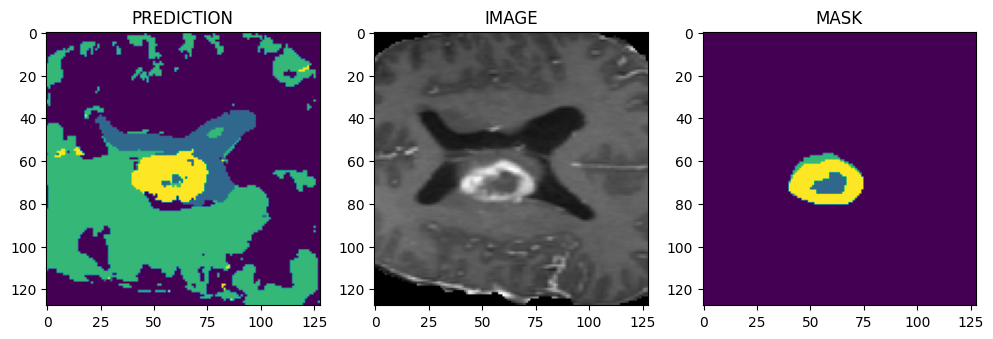

In [92]:
plt.figure(figsize=(12,6))

slice = 70

plt.subplot(131)
plt.title('PREDICTION')
plt.imshow(val_pred[:,:])
plt.subplot(132)
plt.title('IMAGE')
plt.imshow(val_img[:,:,1], cmap='gray')
plt.subplot(133)
plt.title('MASK')
plt.imshow(val_msk[:,:])

In [93]:
with torch.no_grad():
    test_loss = 0
    test_acc = 0

    for images, masks in val_img_datagen:
        images = images.float().to(device=DEVICE)
        labels = masks.float().to(device=DEVICE)
        masks = torch.transpose(torch.transpose(masks, 1, -1), 2, -1)

        preds = modelLoad(torch.transpose(torch.transpose(images, 1, -1), 2, -1))

        loss = multi_dice(preds,masks)
        print(loss)
        test_loss += loss.item()

        test_acc += multi_IoU(preds, masks).item()
        print('accuracy',test_acc)

    test_loss /= len(val_img_datagen)
    test_acc /= len(val_img_datagen)

print('validation loss:', test_loss)
print('validation accuracy:', test_acc)

tensor(0.6678)
accuracy 0.7778768539428711
tensor(0.7386)
accuracy 1.6125150322914124
tensor(0.7361)
accuracy 2.4381543397903442
tensor(0.7504)
accuracy 3.2767640352249146
tensor(0.7399)
accuracy 4.111366271972656
tensor(0.7770)
accuracy 4.963280558586121
tensor(0.7684)
accuracy 5.80891615152359
validation loss: 0.7397541574069432
validation accuracy: 0.82984516450337
